# Linear Regression

In [1]:
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.2 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: matplotlib-inl

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

## Defining the Model

- Initialize weights by drawing random numbers from a normal distribution with mean 0 and a standard deviation of 0.01
- set bias 0

In [2]:
class LinearRegressionScratch(d2l.Module):
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

- weight **w**, input features **X**, bias **b**(scalar)

In [3]:
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

## Defining the Loss Function

- transform true value y into the predicted value's shape y_hat
- averaged loss value를 최종결과로 return

In [4]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

## Defining the Optimization Algorithm

과제는 아니지만, 전체적인 deep learning pipeline을 파악해주세요!

In [5]:
class SGD(d2l.HyperParameters):
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [6]:
@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

##Training

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$


In [7]:
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

loss를 확인해봅시다 !

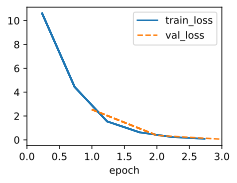

In [8]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

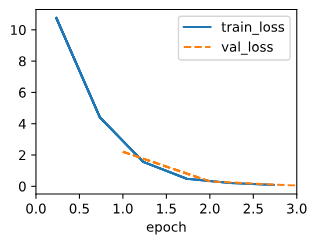

-정답 그림

# Softmax Regression

다양한 X를 설정해서 진행해주셔도 좋을 거 같습니다 :>

In [9]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

(**
$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$$
**)

softmax를 구현해주세요

In [10]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [11]:
X = torch.rand((2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2886, 0.2606, 0.1353, 0.1442, 0.1713],
         [0.1784, 0.1905, 0.1731, 0.2214, 0.2366]]),
 tensor([1., 1.]))

## Model

- 28*28 pixel image를 가지고, flatten하여 vector로 만듦
- 10 class 존재

In [12]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

In [13]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))
    return softmax(torch.matmul(X, self.W) + self.b)

## Cross-Entropy Loss

다양한 y로 연습해보셔도 좋을 거 같습니다 :>

In [14]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

Cross entropy loss를 구현해주세요

In [15]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

cross_entropy(y_hat, y)

tensor(1.4979)

In [16]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

## Training

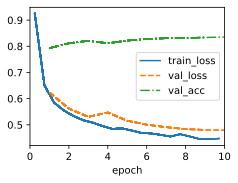

In [17]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

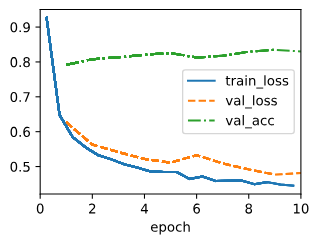
-정답 그림

## Prediction

어떤 방식으로 prediction 및 사진이 나오는지 확인해주세요

In [18]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

torch.Size([256])

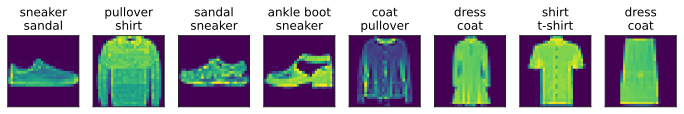

In [19]:
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)